# 0. 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)

seed_everything(42)

# 1. 데이터 load

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv")

# 2. 데이터 전처리
label encoding 이후 one hot encoding 실시

In [3]:
train = train.drop(["ID"], axis = 1)
test = test.drop(["ID"], axis = 1)

train = train[train["주택소유상태"] != "ANY"]

print("train data set")
print("대출등급", train["대출등급"].unique())
print("대출기간", train["대출기간"].unique())
print("근로기간", train["근로기간"].unique())
print("주택소유상태", train["주택소유상태"].unique())
print("대출목적", train["대출목적"].unique(),'\n')

print("test data set")
print("대출기간", test["대출기간"].unique())
print("근로기간", test["근로기간"].unique())
print("주택소유상태", test["주택소유상태"].unique())
print("대출목적", test["대출목적"].unique())

train data set
대출등급 ['C' 'B' 'A' 'D' 'F' 'G' 'E']
대출기간 [' 36 months' ' 60 months']
근로기간 ['6 years' '10+ years' '5 years' '8 years' 'Unknown' '9 years' '2 years'
 '1 year' '3 years' '7 years' '4 years' '< 1 year' '10+years' '<1 year'
 '3' '1 years']
주택소유상태 ['RENT' 'MORTGAGE' 'OWN']
대출목적 ['부채 통합' '주택 개선' '주요 구매' '휴가' '의료' '자동차' '신용 카드' '소규모 사업' '기타' '이사' '주택'
 '재생 에너지'] 

test data set
대출기간 [' 36 months' ' 60 months']
근로기간 ['8 years' '5 years' '6 years' 'Unknown' '10+ years' '3 years' '< 1 year'
 '1 year' '7 years' '4 years' '2 years' '9 years' '10+years' '<1 year' '3'
 '1 years']
주택소유상태 ['MORTGAGE' 'RENT' 'OWN']
대출목적 ['주택 개선' '부채 통합' '신용 카드' '기타' '주요 구매' '이사' '휴가' '소규모 사업' '주택' '의료' '자동차'
 '재생 에너지' '결혼']


In [4]:
mapping_target = {"A" : 1, "B" : 2, "C" : 3, "D" : 4, "E" : 5, "F" : 6, "G" : 7}
train["대출등급"] = train["대출등급"].replace(mapping_target)

mapping_period1 = {" 36 months" : 36, " 60 months" : 60}
train["대출기간"] = train["대출기간"].replace(mapping_period1)
test["대출기간"] = test["대출기간"].replace(mapping_period1)

mapping_period2 = {"Unknown" : 0, "< 1 year" : 1, "<1 year" : 1, "1 year" : 2, "1 years" : 2,
                  "2 years" : 3, "3 years" : 4, "3" : 4, "4 years" : 5, "5 years" : 6,
                  "6 years" : 7, "7 years" : 8, "8 years" : 9, "9 years" : 10 ,"10+ years" : 11,
                  "10+years" : 11}
train["근로기간"] = train["근로기간"].replace(mapping_period2)
test["근로기간"] = test["근로기간"].replace(mapping_period2)

mapping_condition = {"RENT" : 0, "MORTGAGE" : 1, "OWN" : 2}
train["주택소유상태"] = train["주택소유상태"].replace(mapping_condition)
test["주택소유상태"] = test["주택소유상태"].replace(mapping_condition)

mapping_purpose = {"주택 개선" : 0, "부채 통합" : 1, "신용 카드" : 2, "기타" : 3, "주요 구매" : 4, "이사" : 5,
                   "휴가" : 6, "소규모 사업" : 7, "주택" : 8, "의료" : 9, "자동차" : 10, 
                   "재생 에너지" : 11, "결혼" : 3}
train["대출목적"] = train["대출목적"].replace(mapping_purpose)
test["대출목적"] = test["대출목적"].replace(mapping_purpose)

print("train data set")
print("대출등급", train["대출등급"].unique())
print("대출기간", train["대출기간"].unique())
print("근로기간", train["근로기간"].unique())
print("주택소유상태", train["주택소유상태"].unique())
print("대출목적", train["대출목적"].unique(),'\n')

print("test data set")
print("대출기간", test["대출기간"].unique())
print("근로기간", test["근로기간"].unique())
print("주택소유상태", test["주택소유상태"].unique())
print("대출목적", test["대출목적"].unique())

train data set
대출등급 [3 2 1 4 6 7 5]
대출기간 [36 60]
근로기간 [ 7 11  6  9  0 10  3  2  4  8  5  1]
주택소유상태 [0 1 2]
대출목적 [ 1  0  4  6  9 10  2  7  3  5  8 11] 

test data set
대출기간 [36 60]
근로기간 [ 9  6  7  0 11  4  1  2  8  5  3 10]
주택소유상태 [1 0 2]
대출목적 [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [5]:
train["총상환이자"] = train["총상환이자"].astype(int)
train["총연체금액"] = train["총연체금액"].astype(int)
train["연체계좌수"] = train["연체계좌수"].astype(int)

test["총상환이자"] = test["총상환이자"].astype(int)
test["총연체금액"] = test["총연체금액"].astype(int)
test["연체계좌수"] = test["연체계좌수"].astype(int)

train = pd.get_dummies(train, columns = ["근로기간"], dtype=int)
test = pd.get_dummies(test, columns = ["근로기간"], dtype=int)

train = pd.get_dummies(train, columns = ["주택소유상태"], dtype=int)
test = pd.get_dummies(test, columns = ["주택소유상태"], dtype=int)

train = pd.get_dummies(train, columns = ["대출목적"], dtype=int)
test = pd.get_dummies(test, columns = ["대출목적"], dtype=int)

In [6]:
train.to_csv("train_onehotenc.csv", index=False)
test.to_csv("test_onehotenc.csv", index=False)

# 3. 파생변수 생성
다양한 변수들에 대하여 비율들이 대출등급에 유의미한 결과를 줄 것이라고 예상

In [7]:
train = pd.read_csv("train_onehotenc.csv")
test = pd.read_csv("test_onehotenc.csv")

In [8]:
train['상환원금/대출금액'] = train['총상환원금']/train['대출금액']
train['상환이자/대출금액'] = train['총상환이자']/train['대출금액']
train['연체금액/대출금액'] = train['총연체금액']/train['대출금액']
train['상환/대출금액'] = (train["총상환원금"] + train["총상환이자"]) / train["대출금액"]
train['대출금액/계좌수'] = train["대출금액"] / train["총계좌수"]
train['연간소득/대출금액'] = train["연간소득"] / train["대출금액"]
train['상환/연간소득'] = (train["총상환원금"] + train["총상환이자"]) / (train["연간소득"] + 1) # 연간소득이 0인경우를 대비하기 위해 1 추가
train["대출금액/대출기간"] = train["대출금액"] / train["대출기간"]

test['상환원금/대출금액'] = test['총상환원금']/test['대출금액']
test['상환이자/대출금액'] = test['총상환이자']/test['대출금액']
test['연체금액/대출금액'] = test['총연체금액']/test['대출금액']
test['상환/대출금액'] = (test["총상환원금"] + test["총상환이자"]) / test["대출금액"]
test['대출금액/계좌수'] = test["대출금액"] / test["총계좌수"]
test['연간소득/대출금액'] = test["연간소득"] / test["대출금액"]
test['상환/연간소득'] = (test["총상환원금"] + test["총상환이자"]) / (test["연간소득"] + 1) # 연간소득이 0인경우를 대비하기 위해 1 추가
test["대출금액/대출기간"] = test["대출금액"] / test["대출기간"]


In [9]:
# 향후 모델링을 위해 target 데이터 숫자 변경
mapping_target = {1 : 0, 2 : 1, 3 : 2, 4 : 3, 5 : 4, 6 : 5, 7 : 6}
train["대출등급"] = train["대출등급"].replace(mapping_target)

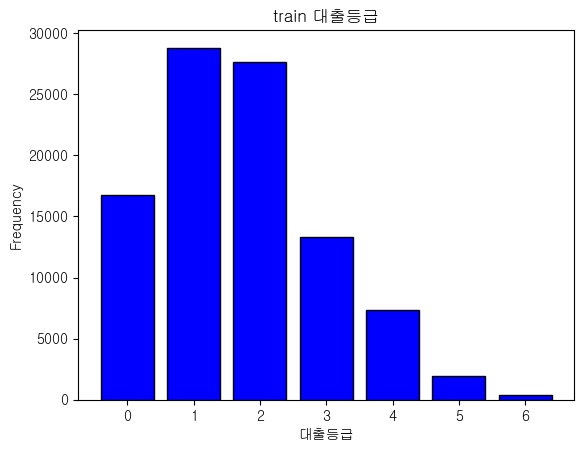

In [10]:
plt.hist(train["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [11]:
train.to_csv("train_final.csv",index = False)
test.to_csv("test_final.csv",index = False)

# 4. Regression
36개월과 60개월 간에 데이터 분포가 확연히 차이가 난다. 따라서 기간별로 나누어서 학습을 진행한다

## 4.1. XGBoost


In [12]:
train = pd.read_csv("train_final.csv")
test = pd.read_csv("test_final.csv")
sub = pd.read_csv("sample_submission.csv")

train_36 = train.loc[train["대출기간"] == 36]
train_60 = train.loc[train["대출기간"] == 60]

### 4.1.1. 36 months
1. ABC(DEFG)
2. D(EFG)
3. E(FG)
4. FG
순으로 각각의 모델을 만들어 분류를 진행한다

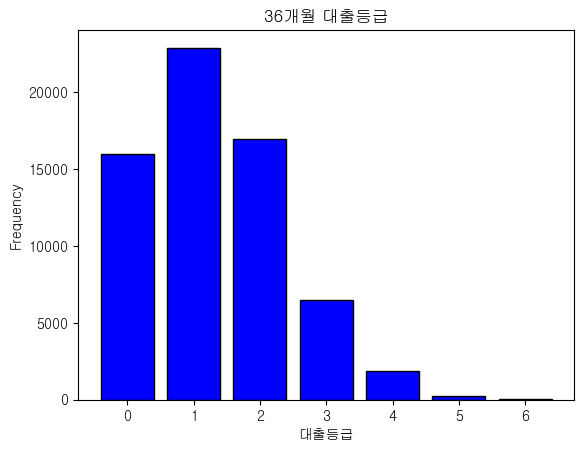

In [13]:
plt.hist(train_36["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("36개월 대출등급")
plt.show()

#### 4.1.1.1. ABC(DEFG)

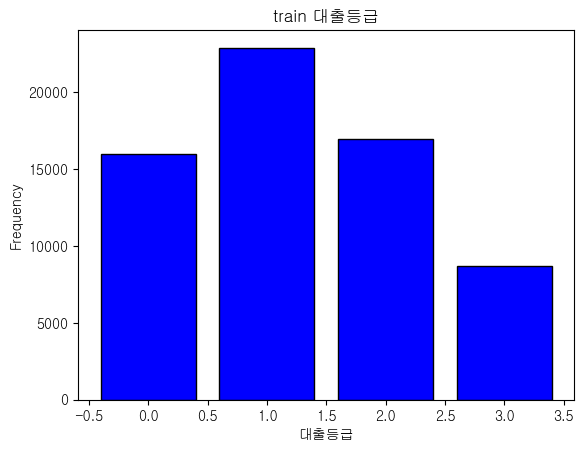

In [14]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

plt.hist(new_train_1["대출등급"], bins=range(5), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [15]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
xg = xgb.XGBRegressor()
model_1 = xg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

0.186931348048766
0.9688134796809048


array([1, 0, 2, 'G'], dtype=object)

#### 4.1.1.2. D(EFG)

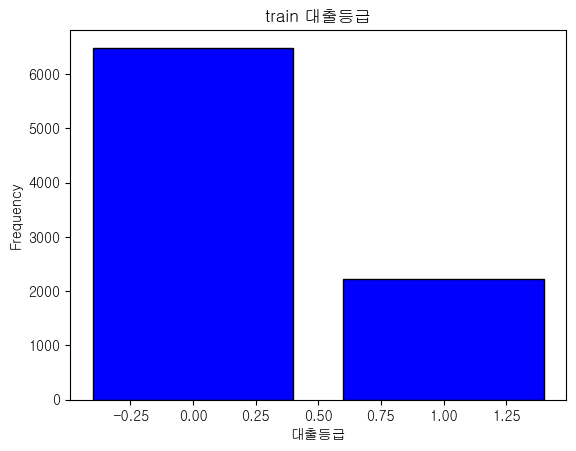

In [16]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

plt.hist(new_train_2["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [17]:
X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

xg = xgb.XGBClassifier()
model_2 = xg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

0.008780717642256245
0.9996915959907479


array([1, 0, 2, 'G', 3], dtype=object)

#### 4.1.1.3 E(FG)

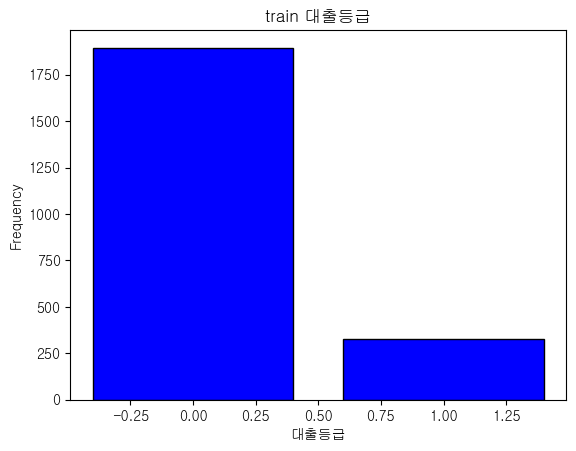

In [18]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]

new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)

plt.hist(new_train_3["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [19]:
X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

xg = xgb.XGBClassifier()
model_3 = xg.fit(X, y)
pred = model_3.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_3 = model_3.predict(test)
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G', 3, 4], dtype=object)

#### 4.1.1.4. FG

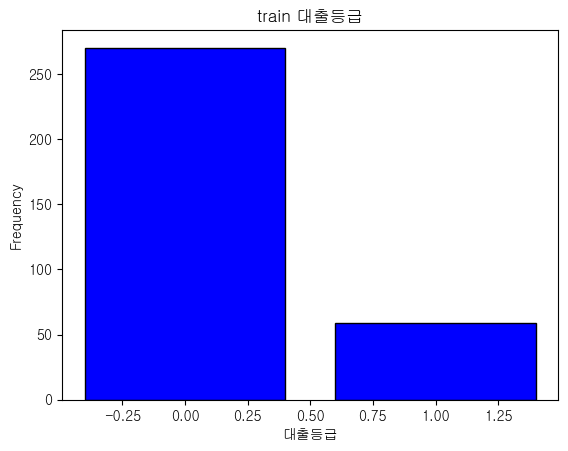

In [20]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]

new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)

plt.hist(new_train_4["대출등급"], bins=range(3), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [21]:
X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

xg = xgb.XGBClassifier()
model_4 = xg.fit(X, y)
pred = model_4.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_4 = model_4.predict(test)
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G', 5, 3, 4, 6], dtype=object)

### 4.1.2. 60months
1. BCDE(AFG)
2. AFG
각각의 모델을 만들어 분류를 진행한다.

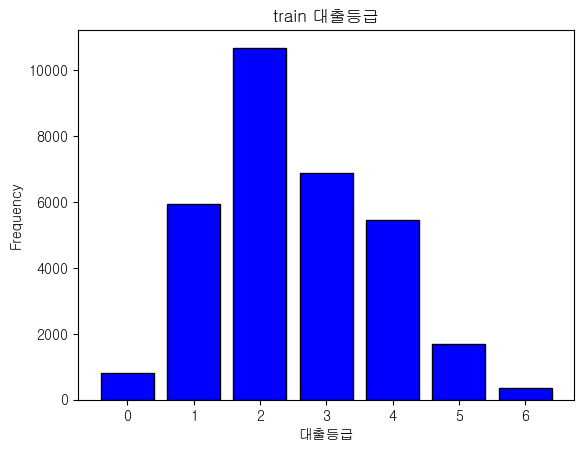

In [22]:
plt.hist(train_60["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

#### 4.1.2.1 BCDE(AFG)

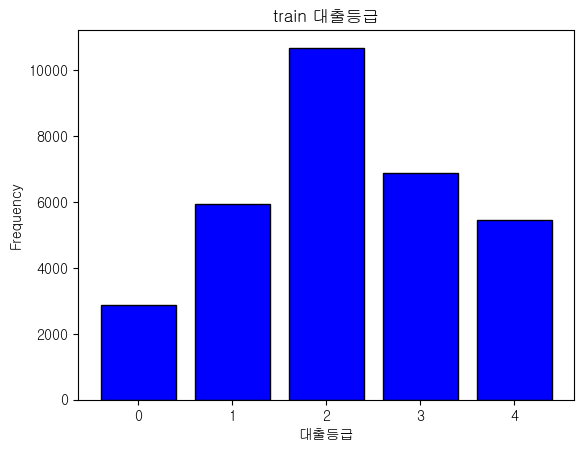

In [23]:
new_train_1 = train_60.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

plt.hist(new_train_1["대출등급"], bins=range(6), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [24]:
X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
xg = xgb.XGBClassifier()
model_1 = xg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 60), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 60), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 60), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 60), "대출등급"] = 4
sub["대출등급"].unique()

0.09246310816324826
0.9939448702070409


array([1, 0, 2, 5, 3, 'G', 4, 6], dtype=object)

#### 4.1.2.2 AFG

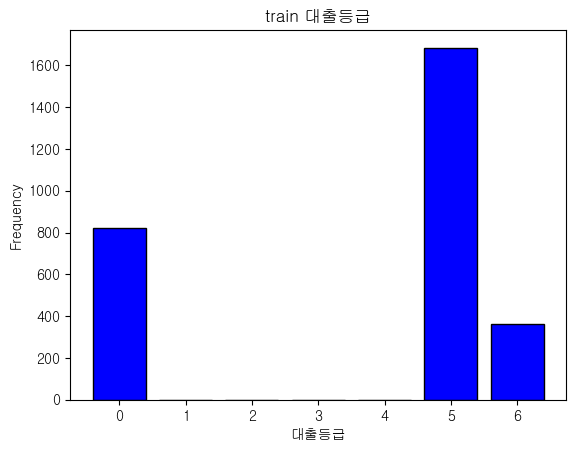

In [25]:
new_train_2 = train_60.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]

plt.hist(new_train_2["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("train 대출등급")
plt.show()

In [26]:
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
xg = xgb.XGBClassifier()
model_2 = xg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 60), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 60), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 60), "대출등급"] = 6
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 5, 3, 4, 6], dtype=object)

### 4.1.3 XGB Result to submission

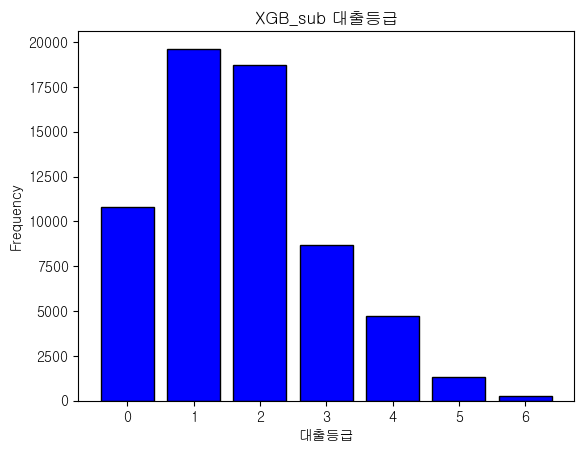

In [27]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("XGB_sub 대출등급")
plt.show()

In [28]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("XGB_reg.csv", index = False)

이후 모델들에는 앞서 XGB Regression의 방법과 같이 진행 하며<br>
분류 모델만 여러 모델로 바꿔서 진행한다

## 4.2 LGBM


In [29]:
train = pd.read_csv("train_final.csv")
test = pd.read_csv("test_final.csv")
sub = pd.read_csv("sample_submission.csv")

train_36 = train.loc[train["대출기간"] == 36]
train_60 = train.loc[train["대출기간"] == 60]

### 4.2.1. 36months
#### 4.2.1.1 ABC(DEFG)

In [30]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
lg = lgb.LGBMRegressor()
model_1 = lg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3283
[LightGBM] [Info] Number of data points in the train set: 64478, number of used features: 44
[LightGBM] [Info] Start training from score 1.319861
0.24309250002342575
0.947259315170247


array([1, 0, 2, 'G'], dtype=object)

#### 4.2.1.2 D(EFG)

In [31]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

lg = lgb.LGBMRegressor()
model_2 = lg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 12970, number of used features: 44
[LightGBM] [Info] Start training from score 0.500000
0.0845469699447291
0.9714072394926603


array([1, 0, 2, 'G', 3], dtype=object)

#### 4.2.1.3. E(FG)

In [32]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]

new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

lg = lgb.LGBMRegressor()
model_3 = lg.fit(X, y)
pred = model_3.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_3 = model_3.predict(test)
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3177
[LightGBM] [Info] Number of data points in the train set: 3790, number of used features: 42
[LightGBM] [Info] Start training from score 0.500000
0.039366541447163665
0.993801101657955


array([1, 0, 2, 'G', 3, 4], dtype=object)

#### 4.2.1.4. FG

In [33]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]

new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

lg = lgb.LGBMRegressor()
model_4 = lg.fit(X, y)
pred = model_4.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_4 = model_4.predict(test)
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 540, number of used features: 34
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

array([1, 0, 2, 'G', 6, 3, 4, 5], dtype=object)

### 4.2.2. 60 months
#### 4.2.2.1. BCDE(AFG)

In [34]:
new_train_1 = train_60.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
lg = lgb.LGBMRegressor()
model_1 = lg.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 60), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 60), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 60), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 60), "대출등급"] = 4
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3259
[LightGBM] [Info] Number of data points in the train set: 31815, number of used features: 43
[LightGBM] [Info] Start training from score 2.192456
0.30845553175267615
0.9326137006911975


array([1, 0, 2, 6, 3, 'G', 4, 5], dtype=object)

#### 4.2.2.2. AFG

In [35]:
new_train_2 = train_60.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

lg = lgb.LGBMRegressor()
model_2 = lg.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 60), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 60), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 60), "대출등급"] = 6
sub["대출등급"].unique()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 2865, number of used features: 38
[LightGBM] [Info] Start training from score 0.839791
0.08606303238764636
0.9808385510584675


array([1, 0, 2, 6, 3, 4, 5], dtype=object)

### 4.2.3. LGBM Result to submission

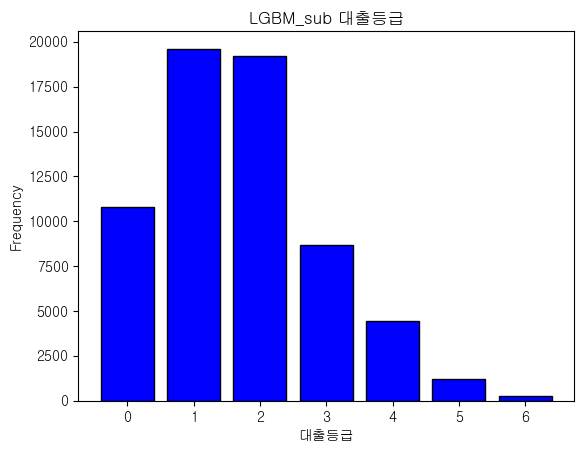

In [36]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("LGBM_sub 대출등급")
plt.show()

In [37]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("LGBM_reg.csv", index = False)

## 4.3 Random Forest

In [38]:
train = pd.read_csv("train_final.csv")
test = pd.read_csv("test_final.csv")
sub = pd.read_csv("sample_submission.csv")

train_36 = train.loc[train["대출기간"] == 36]
train_60 = train.loc[train["대출기간"] == 60]

### 4.3.1. 36months
#### 4.3.1.1 ABC(DEFG)

In [39]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
rf = RandomForestRegressor()
model_1 = rf.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

0.09811345888424897
0.9914086815364075


array([1, 0, 2, 'G'], dtype=object)

#### 4.3.1.2 D(EFG)

In [40]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

rf = RandomForestRegressor()
model_2 = rf.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

0.03536100854347947
0.9949983962991519


array([1, 0, 2, 'G', 3], dtype=object)

#### 4.3.1.3. E(FG)

In [41]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]

new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

rf = RandomForestRegressor()
model_3 = rf.fit(X, y)
pred = model_3.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_3 = model_3.predict(test)
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

0.029425008658701256
0.9965366754617414


array([1, 0, 2, 'G', 3, 4], dtype=object)

#### 4.3.1.4. FG

In [42]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]

new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

rf = RandomForestRegressor()
model_4 = rf.fit(X, y)
pred = model_4.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_4 = model_4.predict(test)
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

0.04490112594480356
0.9919355555555556


array([1, 0, 2, 'G', 6, 3, 4, 5], dtype=object)

### 4.3.2. 60 months
#### 4.3.2.1. BCDE(AFG)

In [43]:
new_train_1 = train_60.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
rf = RandomForestRegressor()
model_1 = rf.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 60), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 60), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 60), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 60), "대출등급"] = 4
sub["대출등급"].unique()

0.12567944526002459
0.9888129651631541


array([1, 0, 2, 6, 3, 'G', 4, 5], dtype=object)

#### 4.3.2.2. AFG

In [44]:
new_train_2 = train_60.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

rf = RandomForestRegressor()
model_2 = rf.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 60), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 60), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 60), "대출등급"] = 6
sub["대출등급"].unique()

0.061367488024094925
0.9902574700178135


array([1, 0, 2, 6, 3, 4, 5], dtype=object)

### 4.3.3. Random Forest Result to submission

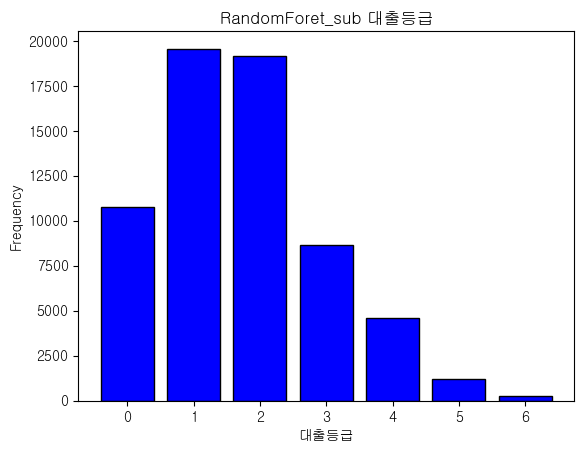

In [45]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("RandomForet_sub 대출등급")
plt.show()

In [46]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("RandomForest_reg.csv", index = False)

## 4.4 Descision Tree

In [47]:
train = pd.read_csv("train_final.csv")
test = pd.read_csv("test_final.csv")
sub = pd.read_csv("sample_submission.csv")

train_36 = train.loc[train["대출기간"] == 36]
train_60 = train.loc[train["대출기간"] == 60]

### 4.4.1. 36months
#### 4.4.1.1 ABC(DEFG)

In [48]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
dt = DecisionTreeRegressor()
model_1 = dt.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G'], dtype=object)

#### 4.4.1.2 D(EFG)

In [49]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

dt = DecisionTreeRegressor()
model_2 = dt.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G', 3], dtype=object)

#### 4.4.1.3. E(FG)

In [50]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]

new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

dt = DecisionTreeRegressor()
model_3 = dt.fit(X, y)
pred = model_3.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_3 = model_3.predict(test)
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G', 3, 4], dtype=object)

#### 4.4.1.4. FG

In [51]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]

new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

dt = DecisionTreeRegressor()
model_4 = dt.fit(X, y)
pred = model_4.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_4 = model_4.predict(test)
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 'G', 3, 4, 5, 6], dtype=object)

### 4.4.2. 60 months
#### 4.4.2.1. BCDE(AFG)

In [52]:
new_train_1 = train_60.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
dt = DecisionTreeRegressor()
model_1 = dt.fit(X, y)
pred = model_1.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_1 = model_1.predict(test)
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 60), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 60), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 60), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 60), "대출등급"] = 4
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 3, 'G', 4, 5, 6], dtype=object)

#### 4.4.2.2. AFG

In [53]:
new_train_2 = train_60.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

dt = DecisionTreeRegressor()
model_2 = dt.fit(X, y)
pred = model_2.predict(X)
print(root_mean_squared_error(y, pred))
print(r2_score(y,pred))

pred_2 = model_2.predict(test)
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 60), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 60), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 60), "대출등급"] = 6
sub["대출등급"].unique()

0.0
1.0


array([1, 0, 2, 3, 4, 5, 6], dtype=object)

### 4.4.3. Descision Tree Result to submission

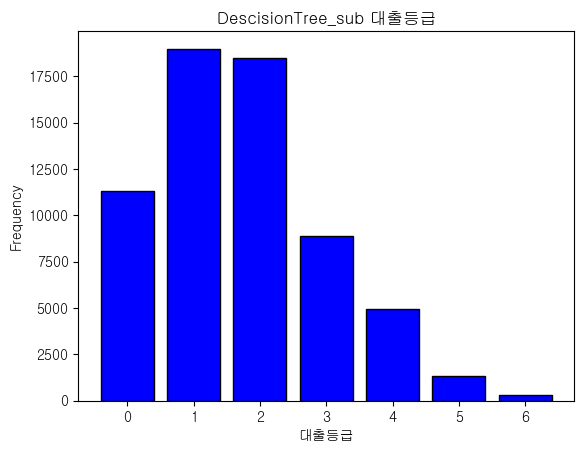

In [54]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("DescisionTree_sub 대출등급")
plt.show()

In [55]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("DecisionTree_reg.csv", index = False)

## 4.5 Cat Boost

In [56]:
train = pd.read_csv("train_final.csv")
test = pd.read_csv("test_final.csv")
sub = pd.read_csv("sample_submission.csv")

train_36 = train.loc[train["대출기간"] == 36]
train_60 = train.loc[train["대출기간"] == 60]

### 4.5.1. 36months
#### 4.5.1.1 ABC(DEFG)

In [57]:
new_train_1 = train_36.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 6 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:4 if x == 7 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
cat = CatBoostRegressor()
model_1 = cat.fit(X, y)
pred = model_1.predict(X)

pred_1 = model_1.predict(test).flatten()
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 0) & (test["대출기간"] == 36), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 36), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 36), "대출등급"] = 2
sub["대출등급"].unique()

Learning rate set to 0.07908
0:	learn: 1.0004656	total: 134ms	remaining: 2m 13s
1:	learn: 0.9474032	total: 144ms	remaining: 1m 11s
2:	learn: 0.8960983	total: 154ms	remaining: 51.1s
3:	learn: 0.8517976	total: 165ms	remaining: 41s
4:	learn: 0.8078454	total: 175ms	remaining: 34.7s
5:	learn: 0.7714533	total: 185ms	remaining: 30.6s
6:	learn: 0.7358034	total: 192ms	remaining: 27.2s
7:	learn: 0.7043471	total: 200ms	remaining: 24.8s
8:	learn: 0.6732566	total: 208ms	remaining: 22.9s
9:	learn: 0.6452308	total: 215ms	remaining: 21.2s
10:	learn: 0.6197575	total: 221ms	remaining: 19.8s
11:	learn: 0.5964320	total: 226ms	remaining: 18.6s
12:	learn: 0.5749819	total: 231ms	remaining: 17.6s
13:	learn: 0.5553948	total: 236ms	remaining: 16.6s
14:	learn: 0.5385206	total: 240ms	remaining: 15.7s
15:	learn: 0.5223109	total: 244ms	remaining: 15s
16:	learn: 0.5085913	total: 248ms	remaining: 14.3s
17:	learn: 0.4951344	total: 252ms	remaining: 13.7s
18:	learn: 0.4836630	total: 255ms	remaining: 13.2s
19:	learn: 0.4

array([1, 0, 2, 'G'], dtype=object)

#### 4.5.1.2 D(EFG)

In [58]:
new_train_2 = train_36.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 0]
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==3 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==4 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

cat = CatBoostRegressor()
model_2 = cat.fit(X, y)
pred = model_2.predict(X)

pred_2 = model_2.predict(test).flatten()
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 36), "대출등급"] = 3
sub["대출등급"].unique()

Learning rate set to 0.06138
0:	learn: 0.4780322	total: 6.02ms	remaining: 6.01s
1:	learn: 0.4586062	total: 10.7ms	remaining: 5.36s
2:	learn: 0.4411900	total: 17ms	remaining: 5.66s
3:	learn: 0.4238443	total: 23.2ms	remaining: 5.77s
4:	learn: 0.4080552	total: 28.3ms	remaining: 5.63s
5:	learn: 0.3927686	total: 33.5ms	remaining: 5.55s
6:	learn: 0.3798500	total: 38.4ms	remaining: 5.45s
7:	learn: 0.3671456	total: 42.3ms	remaining: 5.25s
8:	learn: 0.3550412	total: 46.7ms	remaining: 5.14s
9:	learn: 0.3415344	total: 50.6ms	remaining: 5.01s
10:	learn: 0.3313282	total: 53.8ms	remaining: 4.84s
11:	learn: 0.3222615	total: 57.1ms	remaining: 4.7s
12:	learn: 0.3111721	total: 60.2ms	remaining: 4.57s
13:	learn: 0.3014222	total: 63.3ms	remaining: 4.46s
14:	learn: 0.2919157	total: 66.5ms	remaining: 4.37s
15:	learn: 0.2832794	total: 69.3ms	remaining: 4.26s
16:	learn: 0.2762435	total: 72ms	remaining: 4.17s
17:	learn: 0.2697158	total: 74.7ms	remaining: 4.08s
18:	learn: 0.2645408	total: 77.3ms	remaining: 3.99

array([1, 0, 2, 'G', 3], dtype=object)

#### 4.5.1.3. E(FG)

In [59]:
new_train_3 = train_36.copy()
new_train_3 = new_train_3[new_train_3["대출등급"] != 0]
new_train_3 = new_train_3[new_train_3["대출등급"] != 1]
new_train_3 = new_train_3[new_train_3["대출등급"] != 2]
new_train_3 = new_train_3[new_train_3["대출등급"] != 3]

new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:0 if x==4 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_3["대출등급"] = new_train_3["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_3.drop(columns=['대출등급'])
y = new_train_3[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

cat = CatBoostRegressor()
model_3 = cat.fit(X, y)
pred = model_3.predict(X)

pred_3 = model_3.predict(test).flatten()
pred_3 = np.round(pred_3)
sub.loc[(sub['대출등급'] == 'G') & (pred_3 == 0) & (test["대출기간"] == 36), "대출등급"] = 4
sub["대출등급"].unique()

Learning rate set to 0.050536
0:	learn: 0.4813897	total: 1.77ms	remaining: 1.77s
1:	learn: 0.4656087	total: 3.38ms	remaining: 1.69s
2:	learn: 0.4498533	total: 5.04ms	remaining: 1.68s
3:	learn: 0.4349006	total: 6.76ms	remaining: 1.68s
4:	learn: 0.4187318	total: 8.5ms	remaining: 1.69s
5:	learn: 0.4061845	total: 10ms	remaining: 1.66s
6:	learn: 0.3918305	total: 11.6ms	remaining: 1.64s
7:	learn: 0.3796643	total: 13.2ms	remaining: 1.63s
8:	learn: 0.3672941	total: 14.9ms	remaining: 1.64s
9:	learn: 0.3554671	total: 16.6ms	remaining: 1.64s
10:	learn: 0.3458130	total: 18.7ms	remaining: 1.68s
11:	learn: 0.3364889	total: 20.2ms	remaining: 1.66s
12:	learn: 0.3257790	total: 22.1ms	remaining: 1.68s
13:	learn: 0.3158777	total: 23.9ms	remaining: 1.68s
14:	learn: 0.3073902	total: 25.7ms	remaining: 1.69s
15:	learn: 0.3002476	total: 27.3ms	remaining: 1.68s
16:	learn: 0.2916944	total: 29.1ms	remaining: 1.68s
17:	learn: 0.2844044	total: 30.9ms	remaining: 1.68s
18:	learn: 0.2771624	total: 32.7ms	remaining: 1

array([1, 0, 2, 'G', 3, 4], dtype=object)

#### 4.5.1.4. FG

In [60]:
new_train_4 = train_36.copy()
new_train_4 = new_train_4[new_train_4["대출등급"] != 0]
new_train_4 = new_train_4[new_train_4["대출등급"] != 1]
new_train_4 = new_train_4[new_train_4["대출등급"] != 2]
new_train_4 = new_train_4[new_train_4["대출등급"] != 3]
new_train_4 = new_train_4[new_train_4["대출등급"] != 4]

new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:0 if x==5 else x)
new_train_4["대출등급"] = new_train_4["대출등급"].apply(lambda x:1 if x==6 else x)

X = new_train_4.drop(columns=['대출등급'])
y = new_train_4[['대출등급']]
os = RandomOverSampler(random_state=42)
X, y = os.fit_resample(X, y)

cat = CatBoostRegressor()
model_4 = cat.fit(X, y)
pred = model_4.predict(X)

pred_4 = model_4.predict(test).flatten()
pred_4 = np.round(pred_4)
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 0) & (test["대출기간"] == 36), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_4 == 1) & (test["대출기간"] == 36), "대출등급"] = 6
sub["대출등급"].unique()

Learning rate set to 0.037145
0:	learn: 0.4916171	total: 1.8ms	remaining: 1.8s
1:	learn: 0.4846654	total: 3.15ms	remaining: 1.57s
2:	learn: 0.4784408	total: 4.49ms	remaining: 1.49s
3:	learn: 0.4693724	total: 5.68ms	remaining: 1.41s
4:	learn: 0.4633653	total: 6.91ms	remaining: 1.37s
5:	learn: 0.4576929	total: 8.06ms	remaining: 1.33s
6:	learn: 0.4497938	total: 9.3ms	remaining: 1.32s
7:	learn: 0.4402434	total: 10.5ms	remaining: 1.3s
8:	learn: 0.4331676	total: 11.8ms	remaining: 1.3s
9:	learn: 0.4259445	total: 13.2ms	remaining: 1.31s
10:	learn: 0.4195864	total: 14.5ms	remaining: 1.3s
11:	learn: 0.4129875	total: 15.8ms	remaining: 1.3s
12:	learn: 0.4081518	total: 17.1ms	remaining: 1.3s
13:	learn: 0.4033404	total: 18.3ms	remaining: 1.29s
14:	learn: 0.3979037	total: 19.6ms	remaining: 1.29s
15:	learn: 0.3928096	total: 20.9ms	remaining: 1.28s
16:	learn: 0.3864699	total: 22.2ms	remaining: 1.28s
17:	learn: 0.3788146	total: 23.5ms	remaining: 1.28s
18:	learn: 0.3723191	total: 24.8ms	remaining: 1.28s


array([1, 0, 2, 'G', 5, 3, 4, 6], dtype=object)

### 4.5.2. 60 months
#### 4.5.2.1. BCDE(AFG)

In [61]:
new_train_1 = train_60.copy()
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 5 else x)
new_train_1["대출등급"] = new_train_1["대출등급"].apply(lambda x:0 if x == 6 else x)

X = new_train_1.drop(columns=['대출등급'])
y = new_train_1[['대출등급']]
cat = CatBoostRegressor()
model_1 = cat.fit(X, y)
pred = model_1.predict(X)

pred_1 = model_1.predict(test).flatten()
pred_1 = np.round(pred_1)
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 1) & (test["대출기간"] == 60), "대출등급"] = 1
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 2) & (test["대출기간"] == 60), "대출등급"] = 2
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 3) & (test["대출기간"] == 60), "대출등급"] = 3
sub.loc[(sub['대출등급'] == 'G') & (pred_1 == 4) & (test["대출기간"] == 60), "대출등급"] = 4
sub["대출등급"].unique()

Learning rate set to 0.070729
0:	learn: 1.1478688	total: 4.75ms	remaining: 4.75s
1:	learn: 1.1113900	total: 9.05ms	remaining: 4.51s
2:	learn: 1.0781631	total: 13ms	remaining: 4.33s
3:	learn: 1.0461903	total: 17ms	remaining: 4.23s
4:	learn: 1.0145304	total: 20.8ms	remaining: 4.13s
5:	learn: 0.9840813	total: 24.4ms	remaining: 4.04s
6:	learn: 0.9601405	total: 28.2ms	remaining: 3.99s
7:	learn: 0.9337267	total: 32ms	remaining: 3.97s
8:	learn: 0.9104372	total: 35.6ms	remaining: 3.92s
9:	learn: 0.8842630	total: 39ms	remaining: 3.86s
10:	learn: 0.8620139	total: 42.7ms	remaining: 3.84s
11:	learn: 0.8405939	total: 46.3ms	remaining: 3.81s
12:	learn: 0.8225153	total: 49.8ms	remaining: 3.78s
13:	learn: 0.8041412	total: 53.3ms	remaining: 3.75s
14:	learn: 0.7889979	total: 57.1ms	remaining: 3.75s
15:	learn: 0.7726407	total: 60.5ms	remaining: 3.72s
16:	learn: 0.7553165	total: 63.9ms	remaining: 3.69s
17:	learn: 0.7413277	total: 67.1ms	remaining: 3.66s
18:	learn: 0.7272538	total: 70.5ms	remaining: 3.64s


array([1, 0, 2, 5, 3, 'G', 4, 6], dtype=object)

#### 4.5.2.2. AFG

In [62]:
new_train_2 = train_60.copy()
new_train_2 = new_train_2[new_train_2["대출등급"] != 1]
new_train_2 = new_train_2[new_train_2["대출등급"] != 2]
new_train_2 = new_train_2[new_train_2["대출등급"] != 3]
new_train_2 = new_train_2[new_train_2["대출등급"] != 4]

new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:0 if x==0 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:1 if x==5 else x)
new_train_2["대출등급"] = new_train_2["대출등급"].apply(lambda x:2 if x==6 else x)

X = new_train_2.drop(columns=['대출등급'])
y = new_train_2[['대출등급']]

cat = CatBoostRegressor()
model_2 = cat.fit(X, y)
pred = model_2.predict(X)

pred_2 = model_2.predict(test).flatten()
pred_2 = np.round(pred_2)
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 0) & (test["대출기간"] == 60), "대출등급"] = 0
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 1) & (test["대출기간"] == 60), "대출등급"] = 5
sub.loc[(sub['대출등급'] == 'G') & (pred_2 == 2) & (test["대출기간"] == 60), "대출등급"] = 6
sub["대출등급"].unique()

Learning rate set to 0.048351
0:	learn: 0.6024521	total: 2.67ms	remaining: 2.67s
1:	learn: 0.5855238	total: 4.65ms	remaining: 2.32s
2:	learn: 0.5683492	total: 6.7ms	remaining: 2.23s
3:	learn: 0.5517482	total: 8.59ms	remaining: 2.14s
4:	learn: 0.5360297	total: 10.7ms	remaining: 2.14s
5:	learn: 0.5227771	total: 12.7ms	remaining: 2.1s
6:	learn: 0.5087970	total: 14.8ms	remaining: 2.1s
7:	learn: 0.4935895	total: 17ms	remaining: 2.11s
8:	learn: 0.4807694	total: 19ms	remaining: 2.09s
9:	learn: 0.4678671	total: 20.9ms	remaining: 2.07s
10:	learn: 0.4547035	total: 22.8ms	remaining: 2.05s
11:	learn: 0.4436168	total: 24.6ms	remaining: 2.03s
12:	learn: 0.4326855	total: 26.4ms	remaining: 2s
13:	learn: 0.4210865	total: 28.3ms	remaining: 1.99s
14:	learn: 0.4121236	total: 30ms	remaining: 1.97s
15:	learn: 0.4035011	total: 32.1ms	remaining: 1.97s
16:	learn: 0.3969529	total: 33.5ms	remaining: 1.94s
17:	learn: 0.3885582	total: 35.2ms	remaining: 1.92s
18:	learn: 0.3790137	total: 37ms	remaining: 1.91s
19:	le

array([1, 0, 2, 5, 3, 4, 6], dtype=object)

### 4.5.3. Cat Boost Result to submission

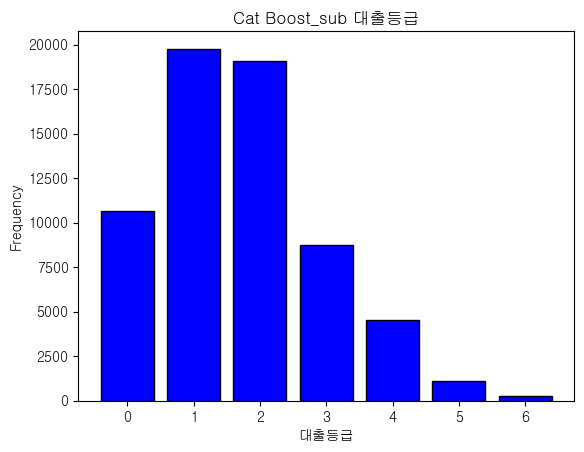

In [63]:
plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')

plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("Cat Boost_sub 대출등급")
plt.show()

In [64]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("CatBoost_reg.csv", index = False)

# 5. Hard Voting

In [65]:
a1 = pd.read_csv("XGB_reg.csv")
a2 = pd.read_csv("LGBM_reg.csv")
a3 = pd.read_csv("RandomForest_reg.csv")
a4 = pd.read_csv("DecisionTree_reg.csv")
a5 = pd.read_csv("CatBoost_reg.csv")
sub = pd.read_csv("sample_submission.csv")

In [66]:
a = a1.copy()
a.columns = ["ID", 69]
a["81_1"] = a2["대출등급"]
a["81_2"] = a3["대출등급"]
a["81_3"] = a4["대출등급"]
a["81_4"] = a5["대출등급"]
a["ans"] = 0
a = a.drop("ID", axis = 1)
a

,69,81_1,81_2,81_3,81_4,ans
0,B,B,B,B,B,0
1,B,B,B,B,B,0
2,A,A,A,A,A,0
3,C,C,C,C,C,0
4,C,C,C,C,C,0
...,...,...,...,...,...,...
64192,D,D,D,D,D,0
64193,D,D,D,D,D,0
64194,D,D,D,D,D,0
64195,C,C,C,C,C,0


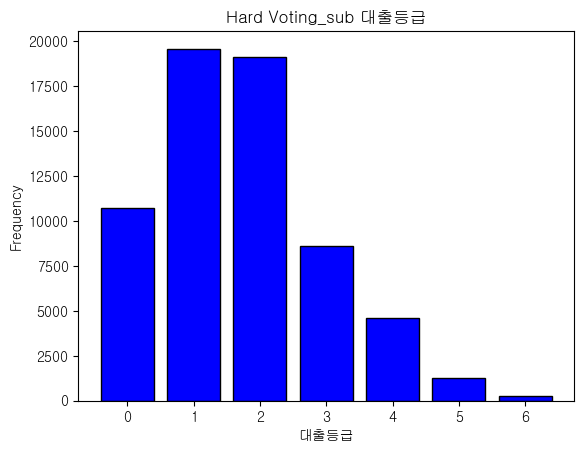

In [67]:
# hard voting에 사용할 함수 생성
def highest_freq_alphabet(row):
    alphabet_counts = row.value_counts()
    most_common_alphabet = alphabet_counts.idxmax()
    return most_common_alphabet

a['ans'] = a.apply(highest_freq_alphabet, axis=1)

mapping_target = {"A" : 0, "B" : 1, "C" : 2, "D" : 3, "E" : 4, "F" : 5, "G" : 6}
a['ans'] = a['ans'].replace(mapping_target)

sub["대출등급"] = a["ans"]

plt.hist(sub["대출등급"], bins=range(8), align='left', rwidth=0.8, color='blue', edgecolor='black')
plt.xlabel("대출등급")
plt.ylabel("Frequency")
plt.title("Hard Voting_sub 대출등급")
plt.show()

In [68]:
mapping_rank = {0 : "A",1 : "B",2 : "C",3 : "D",4 : "E",5 : "F",6 : "G"}
sub["대출등급"] = sub["대출등급"].replace(mapping_rank)
sub.to_csv("Split_by_loan_period_XGB+LGBM+RF+DT+CAT_reg_hard_voting.csv",index=False)